In [2]:
# Our standard imports for maths and basic methodology
import numpy as np

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# General Imports
import itertools
import collections

Let's see if we have a GPU.

In [3]:
if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("No GPU available")

Tesla T4


## Load tagging data

I used corpora form the [https://universaldependencies.org/]
The models will be trained and evaluated on English, Ancient Greek, Russian and German.


In [32]:
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_Afrikaans-AfriBooms/master/af_afribooms-ud-train.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_Afrikaans-AfriBooms/master/af_afribooms-ud-test.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_Bulgarian-BTB/master/bg_btb-ud-train.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_Bulgarian-BTB/master/bg_btb-ud-test.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Tourism/master/tr_tourism-ud-train.conllu
!wget -N https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-Tourism/master/tr_tourism-ud-test.conllu
    

--2021-06-13 11:49:44--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8125779 (7.7M) [text/plain]
Saving to: ‘en_gum-ud-train.conllu’

en_gum-ud-train.con 100%[===================>]   7.75M  25.6MB/s    in 0.3s    

Last-modified header missing -- time-stamps turned off.
2021-06-13 11:49:45 (25.6 MB/s) - ‘en_gum-ud-train.conllu’ saved [8125779/8125779]

--2021-06-13 11:49:45--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

In [23]:
class DataProcess:
    token2idx = None
    tag2idx = None
    def __init__(self,train_path,test_path):
        self.train_path = train_path
        self.test_path = test_path
        
    def pre_processing(self,process):
        if process == "train":
            path = self.train_path
        elif process == "test":
            path = self.test_path
        else:
            print ("Error: you need to specify the process: train or test")
        sent, tag = [], []
        with open(path,"r") as f:
            content = f.read()
        content = content.split("\n\n")
        if content[-1] == "":
            content = content[:-1]

        for line in content:
            word, pos = [],[]
            field = line.split("\n")
            for data in field:
                if data.startswith("#"):
                    continue
                data = data.strip().split('\t')
                word.append(data[1])
                pos.append(data[3])

            sent.append(word)
            tag.append(pos)
        assert len(sent) == len(tag)
        if "train" in path:
            print("The training set includes %i sentences" % len(sent))
        else:
            print("The test set includes %i sentences" % len(sent))
        return sent,tag
    
    def plotting(self,X_set):
        l = np.asarray([len(x) for x in X_set], dtype=np.int)
        plt.figure(figsize=(8, 4))
        x_train = np.unique(l)
        plt.bar(x_train, [np.sum(l==e) for e in x_train], width=1)
        plt.xlabel("Sentence length")
        plt.ylabel("# sentences")
        plt.show()
        
    def dummy_baseline(self, test_set):
        joined = list(itertools.chain.from_iterable(test_set))
        all_tags = len(joined)
        a_counter = collections.Counter(joined)
        most_common = a_counter.most_common()
        common_frequency = most_common[0][1] # tuple (tag,frequency)
        accuracy = common_frequency/all_tags
        print("Baseline accuracy: "+ str(round(accuracy,2)*100)+ "%")

    def to_index(self,X_train,y_train):
        tokens = {token for sentence in X_train for token in sentence}
        idx2token = list(tokens)
        idx2token.insert(0, '<UNK>')
        idx2token.append('<PAD>')
        token2idx = {token:idx for idx, token in enumerate(idx2token)}
        tags = {tag for tags in y_train for tag in tags}
        idx2tag = list(tags)
        idx2tag.append('<PAD>')
        tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}
        DataProcess.token2idx = token2idx
        DataProcess.tag2idx = tag2idx
        
        
    def pad_and_encode(self,sentences, labels):
          assert len(sentences)==len(labels)
          assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
          max_sentence_length = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
          padded_sentences = torch.zeros(len(sentences), max_sentence_length,     # Create data structures with <PAD> as default
                                         dtype=torch.long)
          padded_sentences[:] = self.token2idx['<PAD>']
          padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                                      dtype=torch.long)
          padded_labels[:] = self.tag2idx['<PAD>']
          for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
            for j, token in enumerate(sentence):
              if token in self.token2idx.keys():
                padded_sentences[i, j] = self.token2idx[token]
              else:
                padded_sentences[i, j] = self.token2idx['<UNK>']
            for j, tag in enumerate(tags):
              padded_labels[i, j] = self.tag2idx[tag]

          return padded_sentences, padded_labels


    def batch_iterator(self,sentences,labels, batch_size=64):
      """Helper function for iterating over batches of the data"""
      assert len(sentences) == len(labels)
      for i in range(0, len(sentences), batch_size):
        X, y= self.pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], 
                              labels[i:min(i+batch_size, len(sentences))])
        if torch.cuda.is_available():                          # Move data to the GPU, if possible, before yielding it
          yield (X.cuda(), y.cuda())
        else:
          yield (X, y)




## Comments

I made the token2idx and tag2idx global because I will need to use those once out of classes.

I created a dummy baseline based on the most frequent tags, so it predicts the most frequent label in the test set.

## Model

In [24]:
class Tagger(nn.Module,DataProcess):
    def __init__(self,rnn, bi, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, dropout=None):
        """An LSTM based tagger
        word_embedding_dim
        The dimensionality of the word embedding
        lstm_hidden_dim
        The dimensionality of the hidden state in the LSTM
        vocabulary_size
        The number of unique tokens in the word embedding (including <PAD> etc)
        tagset_size
        The number of unique POS tags (not including <PAD>, as we don't want to predict it)
        """
        super(Tagger, self).__init__()                           # We need to initialise the class we are inheriting from
        self.hidden_dim_ = hidden_dim                            # This simply stores the parameters
        self.vocabulary_size_ = vocabulary_size
        self.tagset_size_ = tagset_size
        self.dropout = dropout

        self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                             embedding_dim=word_embedding_dim, 
                                             padding_idx=token2idx['<PAD>'])
        if rnn == "LSTM":
            self._rnn = nn.LSTM(input_size=word_embedding_dim,                 # The LSTM takes an embedded sentence as input, and outputs 
                             hidden_size=hidden_dim,                           # vectors with dimensionality lstm_hidden_dim.
                             batch_first=True,
                             bidirectional=bi)
            
        elif rnn == "GRU":
            self._rnn = nn.GRU(input_size=word_embedding_dim,                         
                             hidden_size=hidden_dim,                           
                             batch_first=True)
            self._fc = nn.Linear(hidden_dim, tagset_size)                      # The linear layer maps from the RNN output space to tag space
        
        if bi == True:
            self._fc = nn.Linear(hidden_dim*2, tagset_size)                    # The linear layer maps from the RNN output space to tag space
        else:
            self._fc = nn.Linear(hidden_dim, tagset_size)                          
        
        if dropout != None:
            self.dropout = nn.Dropout(dropout)
        self._softmax = nn.LogSoftmax(dim=1)                                   # Softmax of outputting PDFs over tags

        self.training_loss_ = list()                                           # For plotting
        self.training_accuracy_ = list()

        if torch.cuda.is_available():                                          # Move the model to the GPU (if we have one)
            self.cuda()

    def forward(self, padded_sentences):
        """The forward pass through the network"""
        batch_size, max_sentence_length = padded_sentences.size()

        embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

        sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
        sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                              batch_first=True, enforce_sorted=False)
        rnn_out, _ = self._rnn(X)                                                 # Run the RNN layer
        X, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)         # Unpack the output from the RNN
        if self.dropout!= None:
            X = self.dropout(X)
        X = X.contiguous().view(-1, X.shape[2])                                     # The output from the RNN layer is flattened
        tag_space = self._fc(X)                                                     # Fully connected layer
        tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs
        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)

    
    
    def train(self,model,X_train,y_train,batch):

        loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])                 # A loss function that fits our choice of output layer and data. The
                                                                                  # loss function will ignore the padding index in the targets.
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)                 # We give the optimiser the parameters to work with, note that we can choose to only give some parameters

        batch_size = batch                                                   # Define the size of each batch
        for epoch in range(10):                                                    # Times to loop over the full dataset
            with tqdm(self.batch_iterator(X_train, y_train, batch_size), 
                total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
                for inputs, targets in batches:                                             # Loop once over the training data
                    model.zero_grad()                                                         # Reset gradients
                    scores = model(inputs)                                          # Forward pass
                    loss = loss_function(scores.view(-1, model.tagset_size_),                 # Get loss, the data is reshaped as a long line of predictions and targets
                                       targets.view(-1))               
                    loss.backward()                                                           # Backpropagate the error
                    optimizer.step()                                                          # Run the optimizer to change the weights w.r.t the loss
                    predictions = scores.argmax(dim=2, keepdim=True).squeeze()                # Calculate the batch training accuracy
                    mask = targets!=tag2idx['<PAD>']                                          # Create a mask for ignoring <PAD> in the targets
                    correct = (predictions[mask] == targets[mask]).sum().item()               # Item pulls the value from the GPU automatically (if needed)
                    accuracy = correct / mask.sum().item()*100
                    model.training_accuracy_.append(accuracy)                                 # Save the accuracy for plotting
                    model.training_loss_.append(loss.item())                                  # Save the loss for plotting
                    batches.set_postfix(loss=loss.item(), accuracy=accuracy)                  # Update the progress bar
    
    def plot(self,model,X_train,batch):
      batch_size = batch
      fig = plt.figure(figsize=(6, 4))
      ax = plt.subplot()
      ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
      ax.plot(model.training_loss_, 'b-')
      ax.set_ylabel("Training Loss", color='b')
      ax.set_xlabel("Epoch")
        # ax.set_yscale('log')
      ax.tick_params(axis='y', labelcolor='b')
      ax = ax.twinx()
      ax.plot(model.training_accuracy_, 'r-')
      ax.set_ylabel("Accuracy [%]", color='r')
      ax.tick_params(axis='y', labelcolor='r')
      a = list(ax.axis())
      a[2] = 0
      a[3] = 100
      ax.axis(a)
      t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
      ax.set_xticks(ticks=t)
      ax.set_xticklabels(labels=np.arange(len(t)))
      fig.tight_layout()
      plt.show()
      return
        
        
    def test(self,model,X_test,y_test,batch_size):
        with torch.no_grad():                        # Do not use the following forward passes to calculate a gradient
            n_correct = 0
            n_total = 0
            for inputs, targets in self.batch_iterator(X_test, y_test, batch_size=batch_size): # Loop once over the test data
                scores = model(inputs)                                                      # Runs the test data through the model
                predictions = scores.argmax(dim=2, keepdim=True).squeeze()                  # Finds the predictions
                mask = targets!=tag2idx['<PAD>']                                            # Create a mask for ignoring <PAD> in the targets
                n_correct += (predictions[mask] == targets[mask]).sum().item()              # Sums the number of correct predictions
                n_total += mask.sum().item()
        print("Test accuracy %.1f%%" % (100*n_correct/n_total))
        
                    

## Quantitative Evaluation

Below, apart from English, three more languages are trained and evaluated. Evaluation is compared per RNN model type (LSTM or GRU), one direction or bi-directional, with and without dropout effect and different dimensionalities.

I provide comments after the multiple evaluations of each corpus and final comparisons at the end of the notebook.

In [33]:
bulgarian_path_train = "./bg_btb-ud-train.conllu"
bulgarian_path_test = "./bg_btb-ud-test.conllu"
english_path_train = "./en_gum-ud-train.conllu"
english_path_test = "./en_gum-ud-test.conllu"
afr_path_train = "./af_afribooms-ud-train.conllu"
afr_path_test = "./af_afribooms-ud-test.conllu"
turkish_path_train = "./tr_tourism-ud-train.conllu"
turkish_path_test = "./tr_tourism-ud-test.conllu"

## English Language

The training set includes 5664 sentences
The test set includes 895 sentences


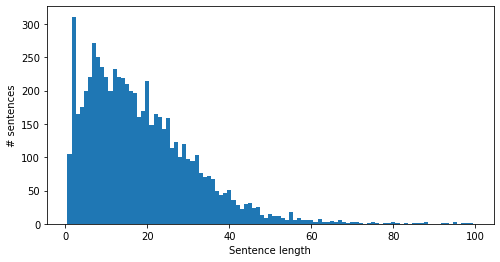

Baseline accuracy: 18.0%


In [57]:
data_class = DataProcess(english_path_train,english_path_test)
X_train, y_train = data_class.pre_processing("train")
X_test, y_test = data_class.pre_processing("test")
data_class.plotting(X_train+X_test)
data_class.to_index(X_train, y_train)
token2idx = data_class.token2idx
tag2idx = data_class.token2idx
data_class.dummy_baseline(y_test)

Epoch 9: 100%|██████████| 23/23 [00:02<00:00,  7.77batch/s, accuracy=97.5, loss=3.63]


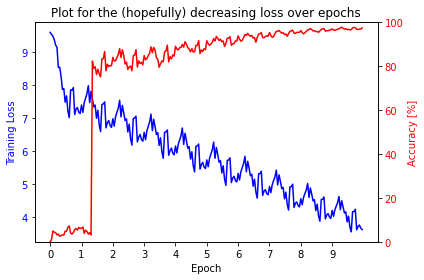

Test accuracy 94.9%


In [59]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         

RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.62batch/s, accuracy=95.5, loss=3.72]


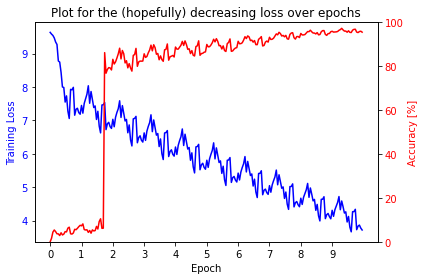

Test accuracy 94.4%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  dropout = 0.2)                         

RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 71/71 [00:03<00:00, 22.63batch/s, accuracy=98.9, loss=0.201]


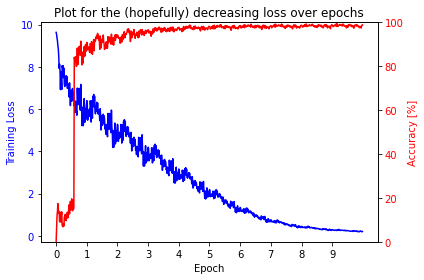

Test accuracy 94.8%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  dropout = 0.2)                         

RNNModel.train(RNNModel,X_train,y_train,batch=80)
RNNModel.plot(RNNModel,X_train,batch =80)
RNNModel.test(RNNModel,X_test,y_test,batch_size=80)

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.57batch/s, accuracy=99.7, loss=3.48]


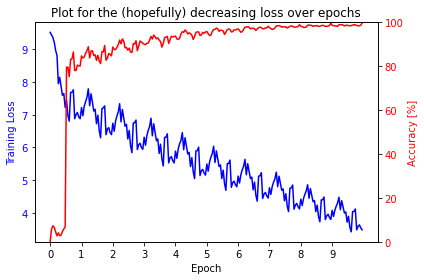

Test accuracy 94.8%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         

RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.56batch/s, accuracy=99.2, loss=3.55]


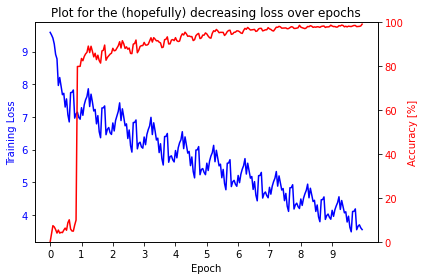

Test accuracy 95.6%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  dropout = 0.2)                         

RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 71/71 [00:03<00:00, 20.07batch/s, accuracy=99.4, loss=0.179]


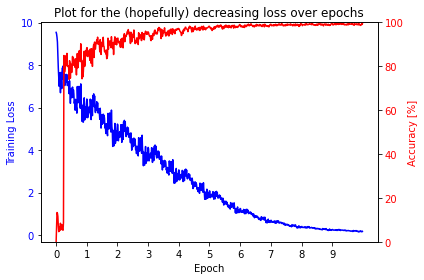

Test accuracy 96.2%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  dropout = 0.2)                         

RNNModel.train(RNNModel,X_train,y_train,batch=80)
RNNModel.plot(RNNModel,X_train,batch =80)
RNNModel.test(RNNModel,X_test,y_test,batch_size=80)

Epoch 9: 100%|██████████| 71/71 [00:04<00:00, 15.85batch/s, accuracy=100, loss=0.158]


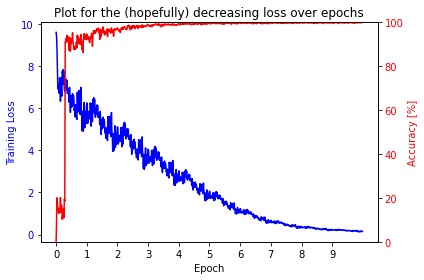

Test accuracy 96.1%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=128,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  dropout = 0.2)                         

RNNModel.train(RNNModel,X_train,y_train,batch=80)
RNNModel.plot(RNNModel,X_train,batch =80)
RNNModel.test(RNNModel,X_test,y_test,batch_size=80)

Epoch 9: 100%|██████████| 71/71 [00:03<00:00, 22.86batch/s, accuracy=98.6, loss=0.204]


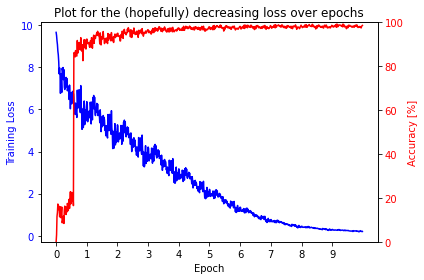

Test accuracy 95.0%


In [ ]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  dropout = 0.2)                         

RNNModel.train(RNNModel,X_train,y_train,batch=80)
RNNModel.plot(RNNModel,X_train,batch =80)
RNNModel.test(RNNModel,X_test,y_test,batch_size=80)

Epoch 9: 100%|██████████| 71/71 [00:03<00:00, 23.54batch/s, accuracy=98.5, loss=0.212]


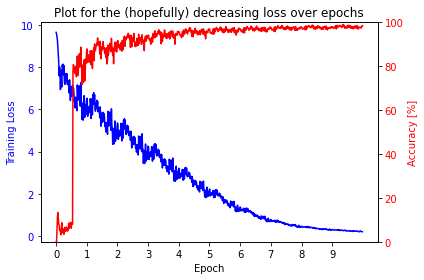

Test accuracy 93.6%


In [ ]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                  )                         

RNNModel.train(RNNModel,X_train,y_train,batch=80)
RNNModel.plot(RNNModel,X_train,batch =80)
RNNModel.test(RNNModel,X_test,y_test,batch_size=80)

 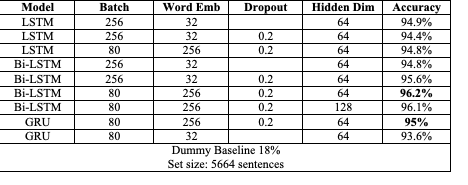

As expected, the bi-LSTM presents better results than the one direction version. This is reasonable since a bi-LSTM model retrieves both future and past information. Also, it brings the best results when combined with dropout effect. Using dropout as a regularization technique means that we reduce overfitting in our network. After changing the embedding dimension from 32 to 256 the results were improved. I also changed the batch size from 256 to 80 because the dataset is not a very big one and that brought the best results. Changing the size of the hidden dimension did not improve the performance. The GRU did not perform better than the bi-LSTM when using similar dropout, batch size and embedding dimension. The GRU has less parameters than an (bi)LSTM network since it lacks the output gate, so it is likely that the explanation lies there. As it emerges from the results, changing the hidden dimension did not seem to affect the accuracy significantly.

## Bulgarian Language

The training set includes 8907 sentences
The test set includes 1116 sentences


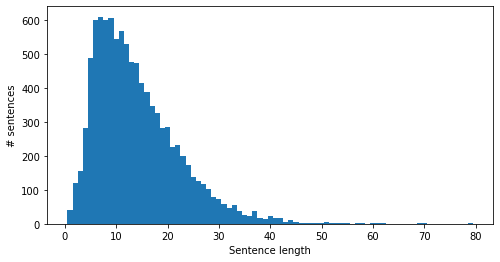

Baseline accuracy: 22.0%


In [34]:
data_class = DataProcess(bulgarian_path_train,bulgarian_path_test)
X_train, y_train = data_class.pre_processing("train")
X_test, y_test = data_class.pre_processing("test")
data_class.plotting(X_train+X_test)
data_class.to_index(X_train, y_train)
token2idx = data_class.token2idx
tag2idx = data_class.token2idx
data_class.dummy_baseline(y_test)

Epoch 9: 100%|██████████| 35/35 [00:04<00:00,  7.61batch/s, accuracy=99.3, loss=2.43]


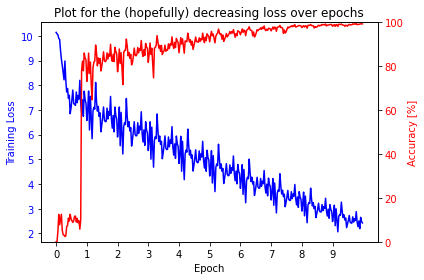

Test accuracy 96.9%


In [35]:

RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)


Epoch 9: 100%|██████████| 35/35 [00:04<00:00,  7.57batch/s, accuracy=98.8, loss=2.42]


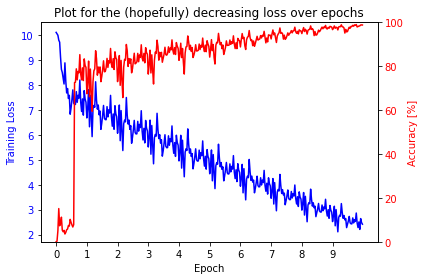

Test accuracy 96.6%


In [36]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 93/93 [00:04<00:00, 20.42batch/s, accuracy=99.5, loss=0.0989]


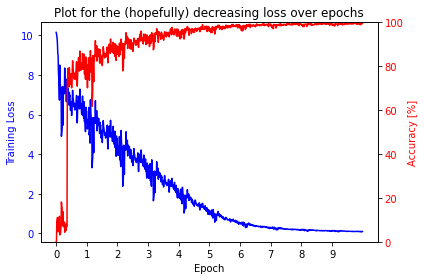

Test accuracy 96.7%


In [37]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 93/93 [00:05<00:00, 17.64batch/s, accuracy=99.7, loss=0.0873]


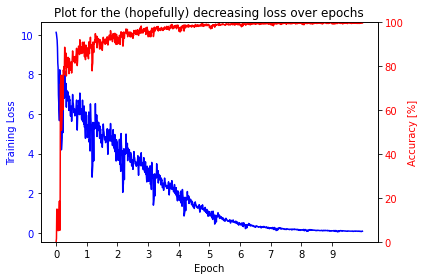

Test accuracy 96.2%


In [38]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 35/35 [00:05<00:00,  6.45batch/s, accuracy=99.7, loss=2.42]


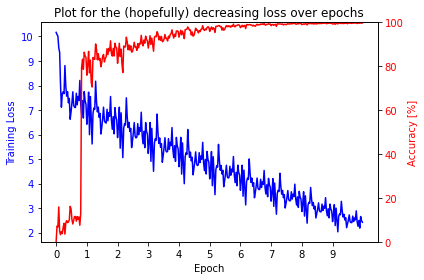

Test accuracy 97.5%


In [39]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)


Epoch 9: 100%|██████████| 93/93 [00:05<00:00, 16.92batch/s, accuracy=99.9, loss=0.078]


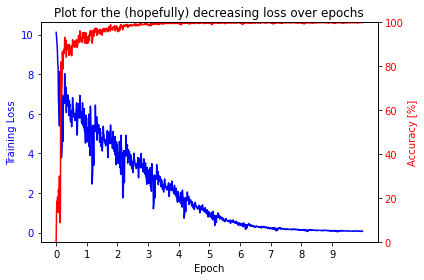

Test accuracy 97.6%


In [40]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)




Epoch 9: 100%|██████████| 93/93 [00:07<00:00, 12.87batch/s, accuracy=100, loss=0.0751]


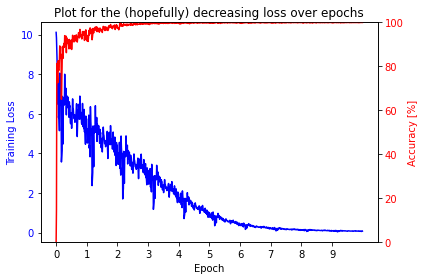

Test accuracy 97.8%


In [41]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=128,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 93/93 [00:04<00:00, 19.71batch/s, accuracy=99.6, loss=0.0863]


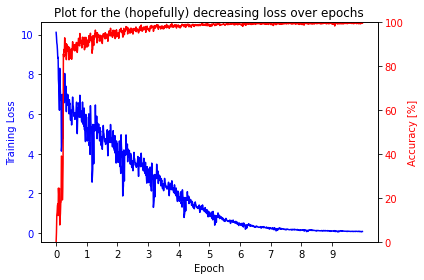

Test accuracy 96.7%


In [42]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 93/93 [00:04<00:00, 20.48batch/s, accuracy=99.3, loss=0.106]


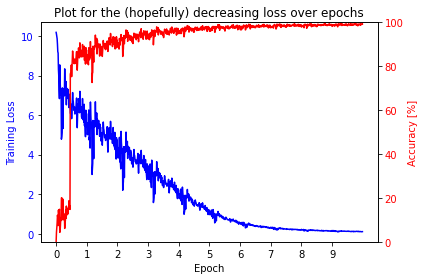

Test accuracy 95.8%


In [43]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)

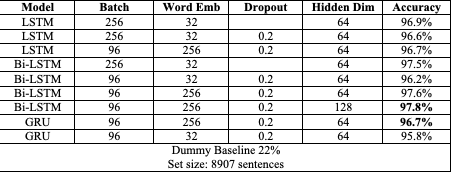

Too be honest, I did not expect this language to achieve high accuracies. The bi-LSTM brings the best results, but the GRU is also very close in accuracy as the bi-LSTM. The dropout effect does not significantly improve the performance, but a higher dimensionality is in need for Bulgarian.

## Turkish Language

The training set includes 15375 sentences
The test set includes 2193 sentences


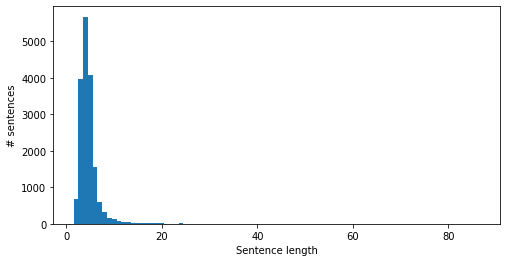

Baseline accuracy: 27.0%


In [44]:
data_class = DataProcess(turkish_path_train,turkish_path_test)
X_train, y_train = data_class.pre_processing("train")
X_test, y_test = data_class.pre_processing("test")
data_class.plotting(X_train+X_test)
data_class.to_index(X_train, y_train)
token2idx = data_class.token2idx
tag2idx = data_class.token2idx
data_class.dummy_baseline(y_test)

Epoch 9: 100%|██████████| 59/59 [00:03<00:00, 15.75batch/s, accuracy=99.5, loss=0.0266]


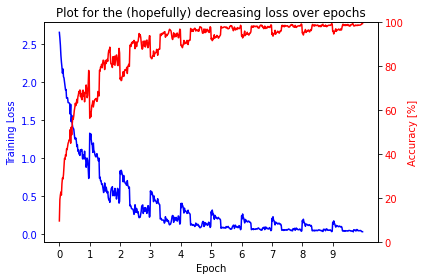

Test accuracy 86.5%


In [ ]:

RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)


Epoch 9: 100%|██████████| 59/59 [00:03<00:00, 15.60batch/s, accuracy=98.7, loss=0.0378]


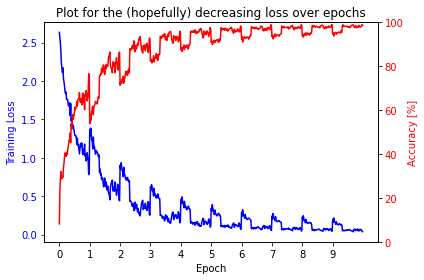

Test accuracy 91.5%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 157/157 [00:05<00:00, 28.04batch/s, accuracy=99.5, loss=0.02]


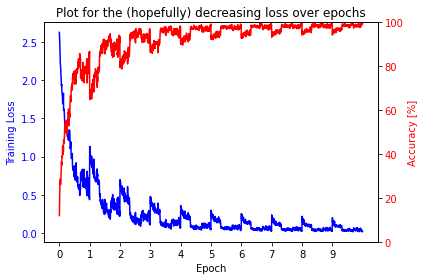

Test accuracy 91.2%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 22.55batch/s, accuracy=100, loss=0.00651]


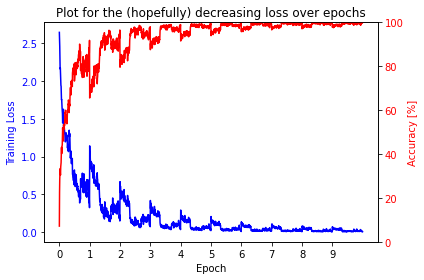

Test accuracy 91.3%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 59/59 [00:04<00:00, 12.05batch/s, accuracy=99.9, loss=0.00815]


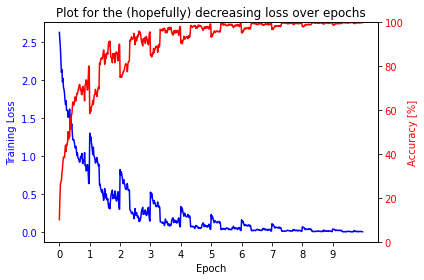

Test accuracy 89.7%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)


Epoch 9: 100%|██████████| 157/157 [00:07<00:00, 20.17batch/s, accuracy=99.8, loss=0.00446]


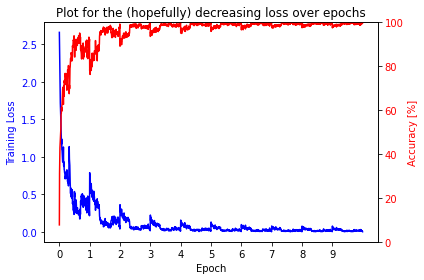

Test accuracy 91.1%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)




Epoch 9: 100%|██████████| 157/157 [00:08<00:00, 18.47batch/s, accuracy=99.8, loss=0.00526]


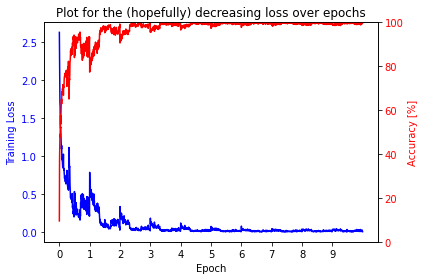

Test accuracy 88.2%


In [ ]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=128,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 157/157 [00:05<00:00, 26.29batch/s, accuracy=99, loss=0.0263]


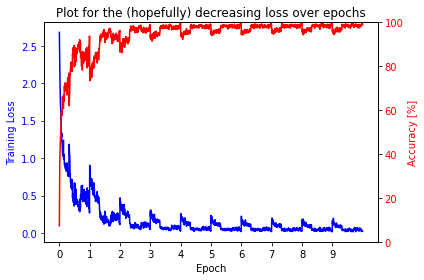

Test accuracy 85.8%


In [ ]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 157/157 [00:05<00:00, 29.26batch/s, accuracy=99, loss=0.0212]


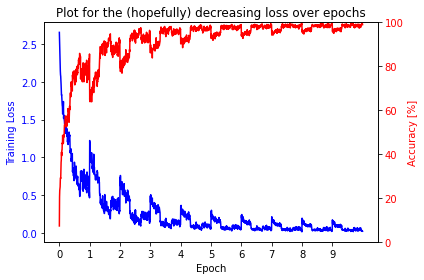

Test accuracy 89.6%


In [ ]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)

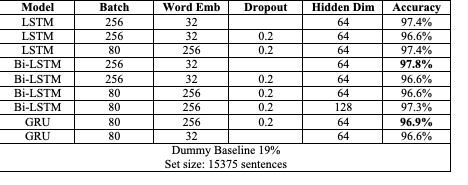

In this language, the dropout technique did not improve the accuracy, meaning that probably the overfitting issue could not be addressed. The bi-LSTM is once again our best model when using a big batch size but relatively small number of word embeddings. What is interesting to mention is that here is no significant difference in the accuracy output when using LSTM and bi-LSTM exists, which probably means that the language is very specific and morphologically rich and most information can be gained forwards. When the embedding dimensionality was higher, the increase of the number in the hidden states also improved the accuracy. The GRU achieved a slightly better accuracy with higher embedding dimensionality.
Overall, all attempts presented pretty good results. 


## Afrikaans Language

The training set includes 1315 sentences
The test set includes 425 sentences


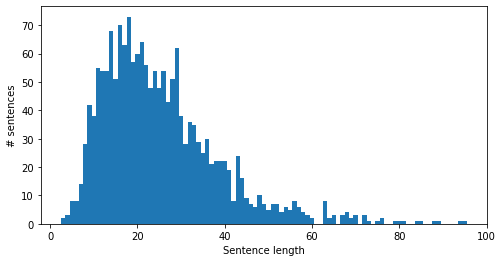

Baseline accuracy: 20.0%


In [47]:
data_class = DataProcess(afr_path_train,afr_path_test)
X_train, y_train = data_class.pre_processing("train")
X_test, y_test = data_class.pre_processing("test")
data_class.plotting(X_train+X_test)
data_class.to_index(X_train, y_train)
token2idx = data_class.token2idx
tag2idx = data_class.token2idx
data_class.dummy_baseline(y_test)

Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 12.30batch/s, accuracy=84.8, loss=5.04]


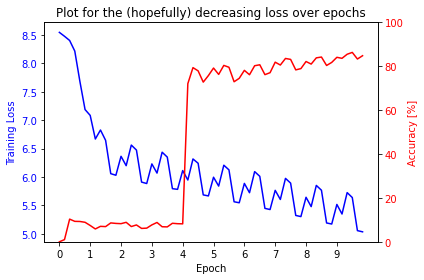

Test accuracy 85.1%


In [48]:

RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 12.67batch/s, accuracy=78.1, loss=5.15]


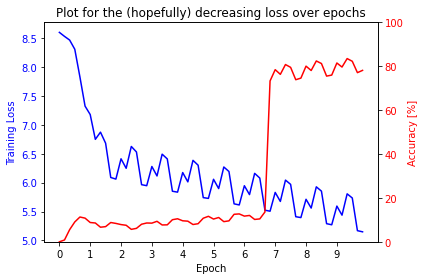

Test accuracy 78.4%


In [49]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)

Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 24.66batch/s, accuracy=95.8, loss=3.86]


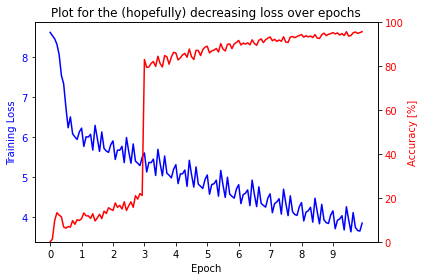

Test accuracy 91.8%


In [50]:
RNNModel = Tagger(rnn = "LSTM",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 22.31batch/s, accuracy=97.8, loss=3.68]


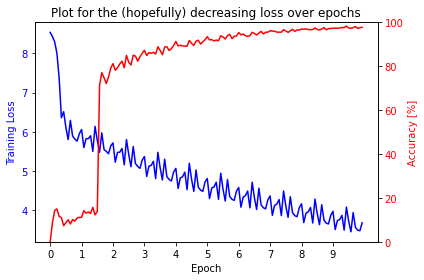

Test accuracy 94.4%


In [51]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 11.15batch/s, accuracy=92.3, loss=4.6]


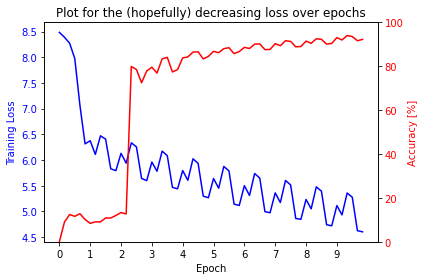

Test accuracy 91.8%


In [52]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1)                         
RNNModel.train(RNNModel,X_train,y_train,batch=256)
RNNModel.plot(RNNModel,X_train,batch =256)
RNNModel.test(RNNModel,X_test,y_test,batch_size=256)


Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 22.40batch/s, accuracy=99.7, loss=3.63]


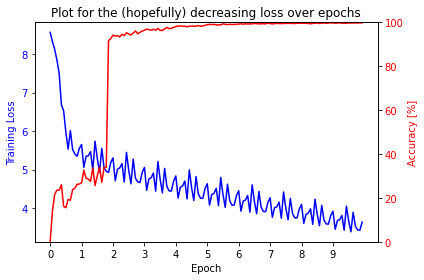

Test accuracy 96.3%


In [53]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)




Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 19.81batch/s, accuracy=99.9, loss=3.55]


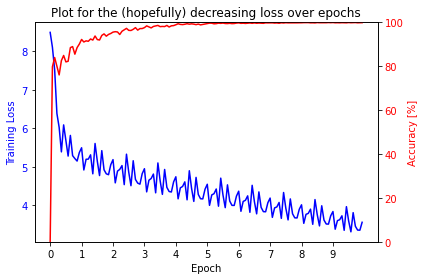

Test accuracy 96.1%


In [54]:
RNNModel = Tagger(rnn = "LSTM",bi=True, word_embedding_dim=256,        
                   hidden_dim=128,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 24.88batch/s, accuracy=99.2, loss=3.67]


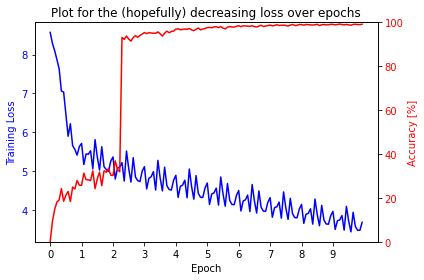

Test accuracy 94.5%


In [55]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=256,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 24.57batch/s, accuracy=96.7, loss=3.76]


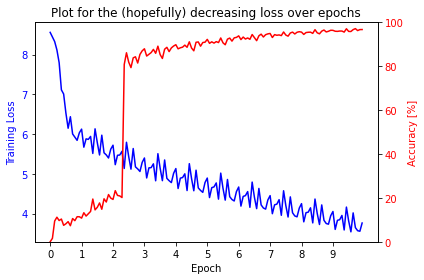

Test accuracy 93.5%


In [56]:
RNNModel = Tagger(rnn = "GRU",bi=False, word_embedding_dim=32,        
                   hidden_dim=64,                                      
                   vocabulary_size=len(token2idx),                     
                   tagset_size=len(tag2idx)-1,
                 dropout = 0.2)                         
RNNModel.train(RNNModel,X_train,y_train,batch=96)
RNNModel.plot(RNNModel,X_train,batch =96)
RNNModel.test(RNNModel,X_test,y_test,batch_size=96)


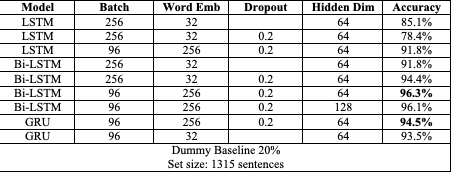

When it comes to Afrikaans, the LSTM and bi-LSTM accuracy are similar, however the bi-LSTM dominates ultimately. Dropout’s functionality reduces significantly overfitting in bi-LSTM, but it does not seem to be the case in LSTM.Best results are presented with a smaller batch size and very high embedding dimensionality. Changes in hidden dimension do not affect the accuracy highly. Whereas the dropout provides lower accuracy in LSTM, with a smaller batch size and high dimensionality, the accuracy improves significantly. The GRU cannot outperform bi-LSTM when applying the corresponding parameters, but seems to bring better results from the LSTM.

### Best Results and final points


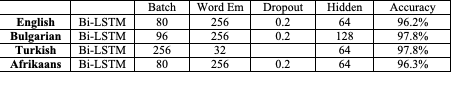

One conclusion we could draw from the above results is that more data is not necessarily better, but it is the nature of the data we are interested in. For instance, the Turkish dataset was almost 2 times bigger than the Bulgarian one, but they presented the same accuracy.   Concerning embedding dimensionality, I think I may have extremely increased the embedding size sometimes; however, the deduction is that Bulgarian and Afrikaans are mostly affected by higher dimensionality, meaning that they are morphologically reach languages. Increasing the hidden state did not bring about significant improvement in accuracy. The latter view is also enhanced by the fact that the differences in bi-LSTM and LSTM accuracies for these languages are extremely small (at least in most times). Finally, the batch size can affect the accuracy of the model at least at some point, depending as well on the size of our dataset.